# VAE
Based off of Alexander Van de Kleut's work. See [this post](https://avandekleut.github.io/vae/) for some theory and explination.

## Checklist
- check your data: make sure the experimental data is not normalized (know expected ranges, it is for sure centered at zero)
- make artificial data more similar to experimental (match the same range)
- loss function values: if we see large numbers not going to zero, double check where the value is coming from (autoencode single example and compare to OG)
    - if you cannot get low loss no matter what, check if you need to add more layers, latent dimensions...
    - should expect good reconstruction capabilities
    - if actually -1 to 1 (check w loop) constrain output with tanh
    - separate loss function (call within forward)
- in artificial data, subtract the mean (of individual image) and subtract from the entire guy

In [55]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/' 
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'
models_folder = parent_folder + 'wonglab-capstone/DotsTorch/Trained_models/'

class ArtKymoDataset(Dataset):
    def __init__(self):
        # Data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        # Mean centering to match artificial data
        for i, kymo in enumerate(kymos):
            kymo = np.divide(kymo,np.mean(kymo))
            kymos[i] = kymo
        kymos = torch.from_numpy(kymos)
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))
        kymos = kymos.astype('float32')
        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

## Convolutional VAE 3.0

In [59]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.convo = nn.Conv2d(1,3,kernel_size=3)
        self.convo2 = nn.Conv2d(3,3,kernel_size=3)
        self.linearMu = nn.Linear(56, latent_dims)
        self.linearSigma = nn.Linear(56, latent_dims)
        self.Normal = torch.distributions.Normal(0,1)
        self.KLDivergence = 0 #Kullback–Leibler divergence

    def forward(self, x):
        x.reshape(1,20,60)
        x = torch.tanh(self.convo(x))
        x = torch.tanh(self.convo2(x))
        mu = self.linearMu(x)
        sigma = torch.exp(self.linearSigma(x))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.KLDivergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #is this actually updating?
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linearDecode = nn.Linear(latent_dims, 7168)
        self.convoT = nn.ConvTranspose2d(3,3,kernel_size=3)
        self.convoT2 = nn.ConvTranspose2d(3,1,kernel_size=3)
        self.linearDownsize = nn.Linear(7172, 1200)

    def forward(self, z):
        z = F.relu(self.linearDecode(z))
        z = torch.tanh(self.convoT(z))
        z = torch.tanh(self.convoT2(z))
        z = self.linearDownsize(z)
        return z.reshape((-1, 1, 20, 60))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### VAE Training Loop

In [62]:
def trainVAE(autoencoder, lr, data, epochs=10, tol = 1000, shuffle=False):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    data_len = len(data)
    past_loss = 0
    if shuffle:
        shuffle_index =  torch.randperm(len(data))
        for epoch in range(epochs):
            startTime = time.perf_counter()
            loss_count = 0
            for i in shuffle_index:
                x = data[i]
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.KLDivergence #try bianary cross entropy here, also check scale of KL, MSE terms
                loss.backward()
                loss_count += loss.item()
                opt.step()
            timediff = (time.perf_counter()-startTime)
            print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
            if abs(past_loss-loss_count) < tol:
                print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
                return autoencoder
            past_loss = loss_count
    else:
        for epoch in range(epochs):
            startTime = time.perf_counter()
            loss_count = 0
            for x in data:
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.KLDivergence
                loss.backward()
                loss_count += loss.item()
                opt.step()
            timediff = (time.perf_counter()-startTime)
            print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
            if abs(past_loss-loss_count) < tol:
                print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
                return autoencoder
            past_loss = loss_count
    return autoencoder

In [63]:
# run the training loop
dataset = ArtKymoDataset()
learning_rate = 1e-5
VAE = Autoencoder(latent_dims=100).to(device)
VAE = trainVAE(VAE, lr=learning_rate, data=dataset, epochs=10, shuffle=True)

	Epoch 1 complete 	Average Loss: 5675.764 	Training time: 57.612 
	Epoch 2 complete 	Average Loss: 3899.350 	Training time: 55.523 
	Epoch 3 complete 	Average Loss: 3715.613 	Training time: 52.244 
	Epoch 4 complete 	Average Loss: 3513.900 	Training time: 49.210 
	Epoch 5 complete 	Average Loss: 3341.815 	Training time: 48.501 
	Epoch 6 complete 	Average Loss: 3217.473 	Training time: 57.409 
	Epoch 7 complete 	Average Loss: 3134.435 	Training time: 34.132 
	Epoch 8 complete 	Average Loss: 3082.667 	Training time: 39.453 
	Epoch 9 complete 	Average Loss: 3051.768 	Training time: 34.751 
	Epoch 10 complete 	Average Loss: 3033.856 	Training time: 36.116 


In [64]:
print(VAE)

Autoencoder(
  (encoder): Encoder(
    (convo): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (convo2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (linearMu): Linear(in_features=56, out_features=100, bias=True)
    (linearSigma): Linear(in_features=56, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (linearDecode): Linear(in_features=100, out_features=7168, bias=True)
    (convoT): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (convoT2): ConvTranspose2d(3, 1, kernel_size=(3, 3), stride=(1, 1))
    (linearDownsize): Linear(in_features=7172, out_features=1200, bias=True)
  )
)


In [65]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            plt.scatter(z[dims[0]], z[dims[1]], c='b', label = ('pol' if i == 101 else None), alpha = 0.8)
        else:
            plt.scatter(z[dims[0]], z[dims[1]], c='g', label = ('rand' if i == 201 else None), alpha = 0.5)

    if exp_data != None:
        for i, z in enumerate(exp_data):
            z.reshape(1,20,60)
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None), alpha = 0.3)



    plt.xlabel('Latent Dim {}'.format(dims[0]))
    plt.ylabel('Latent Dim {}'.format(dims[1]))
    plt.legend(loc='upper right')
    plt.title('Kymograph position in Latent Space')
    plt.legend

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(3):
        idz = np.random.randint(0,len(data))
        y = data[idz]
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(y[0,:,:], cmap='gray')
        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

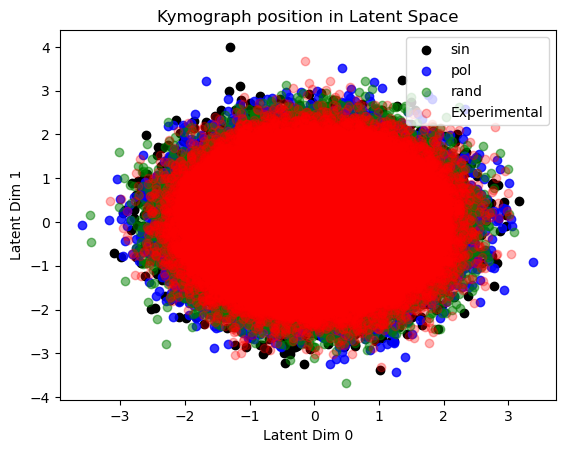

In [66]:
exp_dataset = ExpKymoDataset()
plot_latent(VAE, dataset, dims=[0,1], exp_data=exp_dataset)

# Current model needs more normalization, still large gaps in latent space...
# Implement PCA to compress latent_dims for visualization?
# Also should implement batching if possible, right now we iterate through entire
# dataset in the same order, probably leading to wonky reconstructions below as model overfits

We can see that the VAE is not doing a very good job at producing meaningful recondstructions however...
This is potentially because it is compressing into at pretty low dimensional latent space, giving it control only over total and relative brightness and some other unclear parameters, hence why all the reconstructed kymos look like scaled copies of one another despite separation in the latent space.

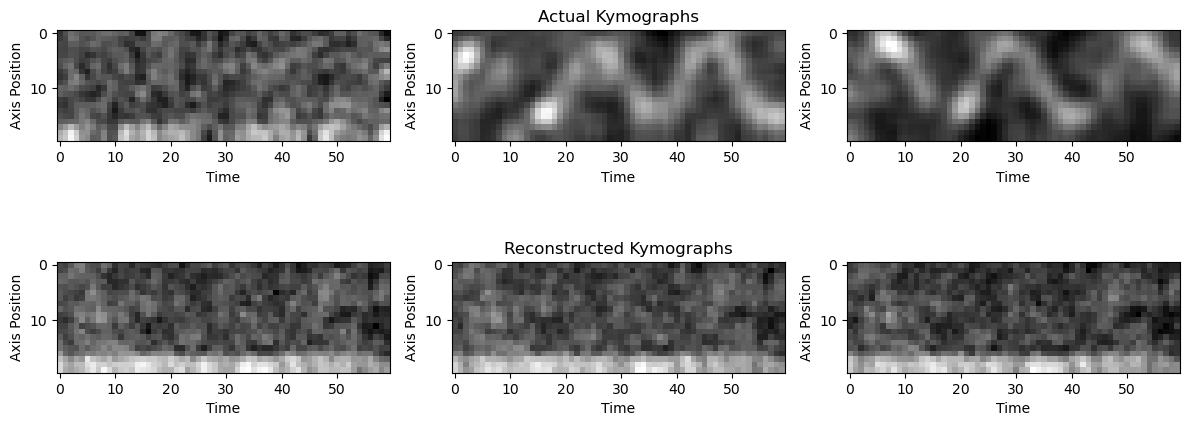

In [67]:
# Sample reconstructed kymographs
plot_sample_im(VAE, dataset)

## Save and load models

Check actual output from decoder and look at how it compares to the input. Error should not be 

In [35]:
# Set save_model = True and run cell to save model state
save_model = False
model_name = 'VAE_3.0.pt'

if save_model:
    torch.save(VAE.state_dict(), models_folder+model_name)

In [ ]:
# Set load_model = True and run cell to save model state
load_model = False
model_name = 'VAE_3.0.pt'

model = Autoencoder(latent_dims=2).to(device)
model.load_state_dict(torch.load(models_folder+model_name))
model.eval()